# Renewable Energy Complementarity & Weather Variability Analysis



This notebook analyzes the complementarity between Solar and Wind power, as well as Offshore vs. Onshore Wind, using the metrics defined in *Water 2025, 17, 2127*.



## Input Data

The analysis uses NetCDF outputs from the `weather_energy_monthly.py` script:

1. `energy_country_timeseries/{year}/{month}_{year}_pv_wind_country_timeseries.nc` (Aggregated Country Data)

2. `per_farm_production/{year}/{month}_{year}_pv_wind_grid.nc` (Gridded Data for Technology splits)

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import matplotlib.dates as mdates

sns.set_theme(style="whitegrid")
# plt.style.use('./custom_latex_style.mplstyle')
plt.rcParams['figure.figsize'] = [16, 9]

## 1. Define Complementarity Metrics

Based on the article *"Analysis of Wind and Solar Scenarios"* (Water 2025, 17, 2127), we define the following four metrics to assess the synergy between wind ($N_w$) and solar ($N_s$) power, and their combined output ($N_{ws} = N_w + N_s$).

### 1. Pearson Correlation Coefficient ($r$)
Quantifies the linear relationship between two variables. A value close to $-1$ indicates strong complementarity (anti-correlation).

$$ 
r = \frac{\sum_{i=1}^T (N_w(i) - \bar{N}_w)(N_s(i) - \bar{N}_s)}{\sqrt{\sum_{i=1}^T (N_w(i) - \bar{N}_w)^2} \sqrt{\sum_{i=1}^T (N_s(i) - \bar{N}_s)^2}} 
$$

### 2. Standard Deviation-Based Complementarity Rate ($R_{SD}$)
Measures how much the fluctuation (standard deviation) of the combined output reduces compared to the sum of individual fluctuations. A value closer to $1$ indicates better complementarity.

$$ 
R_{SD} = \frac{(\sigma(N_w) + \sigma(N_s)) - \sigma(N_{ws})}{\sigma(N_w) + \sigma(N_s)} \times 100\% 
$$

Where the standard deviation $\sigma(X)$ is:
$$ 
\sigma(X) = \sqrt{\frac{1}{T} \sum_{t=1}^{T} (x_t - \bar{x})^2} 
$$

### 3. Richard-Baker Flashiness Complementarity Rate ($R_{RBF}$)
Uses the **Richard-Baker Flashiness Index (RBF)**, which measures oscillations relative to the total generation.

$$ 
R_{RBF} = \frac{(RBF(N_w) + RBF(N_s)) - RBF(N_{ws})}{RBF(N_w) + RBF(N_s)} \times 100\% 
$$

Where the RBF index is calculated as:
$$ 
RBF(X) = \frac{\sum_{t=2}^{T-1} 0.5 \times (|x_t - x_{t-1}| + |x_{t+1} - x_t|)}{\sum_{t=1}^T x_t} 
$$

### 4. First-Order Difference Complementarity Rate ($R_{FD}$)
Based on the average absolute difference between adjacent time steps (ramp rates).

$$ 
R_{FD} = \frac{(|\Delta N_w| + |\Delta N_s|) - |\Delta N_{ws}|}{|\Delta N_w| + |\Delta N_s|} \times 100\% 
$$

Where the first-order difference $|\Delta X|$ is:
$$ 
|\Delta X| = \frac{1}{T - 1} \sum_{t=1}^{T-1} |x_{t+1} - x_t| 
$$

In [2]:
def calculate_metrics(s1: pd.Series, s2: pd.Series):
    """
    Calculates complementarity metrics between two time series s1 and s2.
    Returns a dictionary of metrics.
    """
    #alignment and remove NaNs
    df = pd.DataFrame({'s1': s1, 's2': s2}).dropna()
    s1, s2 = df['s1'], df['s2']
    combined = s1 + s2
    
    #1. Pearson Correlation (r)
    pearson_r = s1.corr(s2)
    
    #2. Standard Deviation Complementarity Rate (R_SD)
    std_sum = s1.std() + s2.std()
    if std_sum == 0:
        r_sd = 0
    else:
        r_sd = (std_sum - combined.std()) / std_sum
        
    #3. Richard-Baker Flashiness (RBF)
    def calc_rbf(series):
        if series.sum() == 0: return 0
        vals = series.values
        #|xt - xt-1|
        diff_backward = np.abs(vals[1:] - vals[:-1]) 
        #|xt+1 - xt|
        term = 0.5 * (diff_backward[1:] + diff_backward[:-1])
        return np.sum(term) / np.sum(series)

    rbf1 = calc_rbf(s1)
    rbf2 = calc_rbf(s2)
    rbf_comb = calc_rbf(combined)
    
    if (rbf1 + rbf2) == 0:
        r_rbf = 0
    else:
        r_rbf = (rbf1 + rbf2 - rbf_comb) / (rbf1 + rbf2)

    #4. First-Order Difference Complementarity Rate (R_FD)
    def calc_fd(series):
        return series.diff().abs().mean()
        
    fd1 = calc_fd(s1)
    fd2 = calc_fd(s2)
    fd_comb = calc_fd(combined)
    
    if (fd1 + fd2) == 0 or pd.isna(fd1):
        r_fd = 0
    else:
        r_fd = (fd1 + fd2 - fd_comb) / (fd1 + fd2)

    return {
        'Pearson_r': pearson_r,
        'R_SD': r_sd,
        'R_RBF': r_rbf,
        'R_FD': r_fd
    }

In [3]:
def calculate_daily_metrics(s1: pd.Series, s2: pd.Series):
    """
    Calculates complementarity metrics on a DAILY basis.
    
    Parameters:
    -----------
    s1 : pd.Series (e.g., Wind) - Expected to be hourly data
    s2 : pd.Series (e.g., Solar) - Expected to be hourly data
    
    Returns:
    --------
    pd.DataFrame : Index is Date, columns are ['Pearson_r', 'R_SD', 'R_RBF', 'R_FD']
    """
    df = pd.DataFrame({'s1': s1, 's2': s2}).dropna()

    def get_rbf(arr):
        total_sum = np.sum(arr)
        if total_sum == 0: return 0
        
        vals = arr
        diff_backward = np.abs(vals[1:] - vals[:-1]) 
    
        if len(diff_backward) < 2: return 0
        
        term = 0.5 * (diff_backward[1:] + diff_backward[:-1])
        return np.sum(term) / total_sum

    daily_results = {}
    
    grouped = df.groupby(df.index.date)
    
    for date, group in grouped:
        if len(group) < 20: 
            continue
            
        d_s1 = group['s1'].values
        d_s2 = group['s2'].values
        d_comb = d_s1 + d_s2
        
        if np.std(d_s1) == 0 or np.std(d_s2) == 0:
            pearson_r = np.nan
        else:
            pearson_r = np.corrcoef(d_s1, d_s2)[0, 1]
            
        std1 = np.std(d_s1, ddof=1) #
        std2 = np.std(d_s2, ddof=1)
        std_comb = np.std(d_comb, ddof=1)
        
        denom_sd = std1 + std2
        r_sd = (denom_sd - std_comb) / denom_sd if denom_sd > 0 else 0
        
        rbf1 = get_rbf(d_s1)
        rbf2 = get_rbf(d_s2)
        rbf_comb = get_rbf(d_comb)
        
        denom_rbf = rbf1 + rbf2
        r_rbf = (denom_rbf - rbf_comb) / denom_rbf if denom_rbf > 0 else 0
        
        fd1 = np.mean(np.abs(np.diff(d_s1)))
        fd2 = np.mean(np.abs(np.diff(d_s2)))
        fd_comb = np.mean(np.abs(np.diff(d_comb)))
        
        denom_fd = fd1 + fd2
        r_fd = (denom_fd - fd_comb) / denom_fd if denom_fd > 0 else 0
        
        daily_results[date] = {
            'Pearson_r': pearson_r,
            'R_SD': r_sd,
            'R_RBF': r_rbf,
            'R_FD': r_fd
        }
        
    return pd.DataFrame(daily_results).T

## 2. Load Data

We load the aggregated country timeseries for the analysis.

In [4]:
BASE_DIR = Path("/Data/gfi/vindenergi/nab015/highres-renewable-dataset")
COUNTRY_DIR = BASE_DIR / "country-aggregated-production"
GRID_DIR = BASE_DIR / "per-farm-production"
YEARS = ["2024"] #Add more years if available

def load_country_data(years):
    ds_list = []
    for year in years:
        #Find all monthly files for the year
        files = sorted(list((COUNTRY_DIR / year).glob("*_pv_wind_country_timeseries.nc")))
        if not files:
            print(f"No files found for year {year}")
            continue
        
        ds_year = xr.open_mfdataset(files, concat_dim="time", combine="nested")
        ds_list.append(ds_year)
    
    if not ds_list:
        return None
    
    return xr.concat(ds_list, dim="time")

ds_country = load_country_data(YEARS)
print("Loaded Country Data:", ds_country)

Loaded Country Data: <xarray.Dataset> Size: 12MB
Dimensions:             (time: 8784, area: 44)
Coordinates:
  * time                (time) datetime64[ns] 70kB 2024-01-01T01:00:00 ... 20...
  * area                (area) <U21 4kB 'Austria (AT)' ... 'Kosovo (XK)'
Data variables:
    pv_power_mw         (time, area) float64 3MB dask.array<chunksize=(93, 11), meta=np.ndarray>
    pv_power_mw_2025    (time, area) float64 3MB dask.array<chunksize=(93, 11), meta=np.ndarray>
    wind_power_mw       (time, area) float64 3MB dask.array<chunksize=(93, 11), meta=np.ndarray>
    wind_power_mw_2025  (time, area) float64 3MB dask.array<chunksize=(93, 11), meta=np.ndarray>
Attributes:
    year:          2024
    month_number:  01
    month_name:    jan
    note:          as-built calibrated factor applied to both as-built and 20...


## 3. Analysis I: Solar vs. Wind (Total) Complementarity

Analyzing the complementarity between `pv_power_mw` and `wind_power_mw` for each bidding zone/country.
Use the **2025** scenario variable (`_2025`) to assess the complementarity of the future planned fleet.

,Pearson_r,R_SD,R_RBF,R_FD
Area,,,,
Austria (AT),-0.210300,0.146199,0.403853,0.068232
Bosnia and Herz. (BA),-0.083722,0.297416,0.582136,0.172259
Belgium (BE),-0.234361,0.353534,0.597475,0.138369
Bulgaria (BG),-0.204941,0.094345,0.341780,0.039044
Switzerland (CH),-0.148636,0.024897,0.293803,0.012458


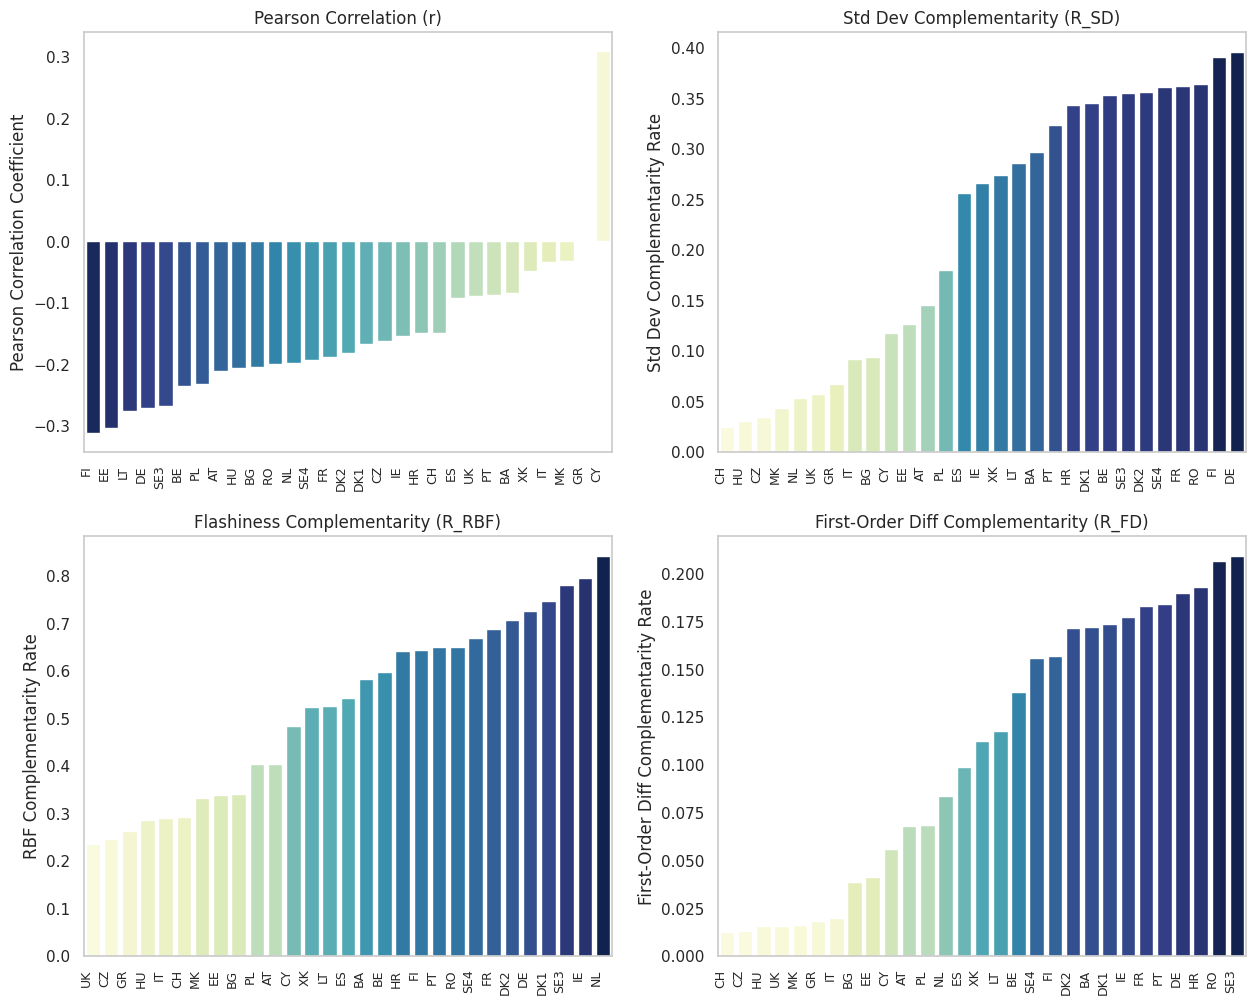

In [10]:
results = []
areas = ds_country.area.values

for area in areas:
    data = ds_country.sel(area=area)
    
    wind = data['wind_power_mw_2025'].to_series()
    solar = data['pv_power_mw_2025'].to_series()
    
    if wind.sum() == 0 or solar.sum() == 0:
        continue

    m = calculate_metrics(wind, solar)
    m['Area'] = area
    results.append(m)

df_complementarity = pd.DataFrame(results).set_index('Area')

display(df_complementarity.head())

def extract_code(area):
    if '(' in area and ')' in area:
        return area.split('(')[-1].replace(')', '').strip()
    else:
        return area.strip()

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metric_cols = ['Pearson_r', 'R_SD', 'R_RBF', 'R_FD']
titles = ['Pearson Correlation (r)', 'Std Dev Complementarity (R_SD)', 'Flashiness Complementarity (R_RBF)', 'First-Order Diff Complementarity (R_FD)']
y_labels = ['Pearson Correlation Coefficient', 'Std Dev Complementarity Rate', 'RBF Complementarity Rate', 'First-Order Diff Complementarity Rate']

for ax, col, title, y_label in zip(axes.flat, metric_cols, titles, y_labels):
    df_sorted = df_complementarity.sort_values(col)
    if col == 'Pearson_r':
        sns.barplot(x=df_sorted.index, y=df_sorted[col], ax=ax, palette=list(reversed(sns.color_palette("YlGnBu", len(df_sorted.index)))), hue=df_sorted[col], dodge=False)
    else:
        sns.barplot(x=df_sorted.index, y=df_sorted[col], ax=ax, palette="YlGnBu", hue=df_sorted[col], dodge=False)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel(y_label)
    ax.grid(axis='y')
    ax.set_xticks(range(len(df_sorted.index)))
    ax.set_xticklabels([extract_code(label) for label in df_sorted.index], fontsize=9, rotation=90, ha='right')
    ax.legend_.remove()  
output_dir = Path(f'/Data/gfi/vindenergi/nab015/figures/complementarity')
plt.savefig(output_dir / f"complementarity_metrics_by_country_{YEARS[0]}-{YEARS[-1]}.svg", bbox_inches="tight", dpi=400)

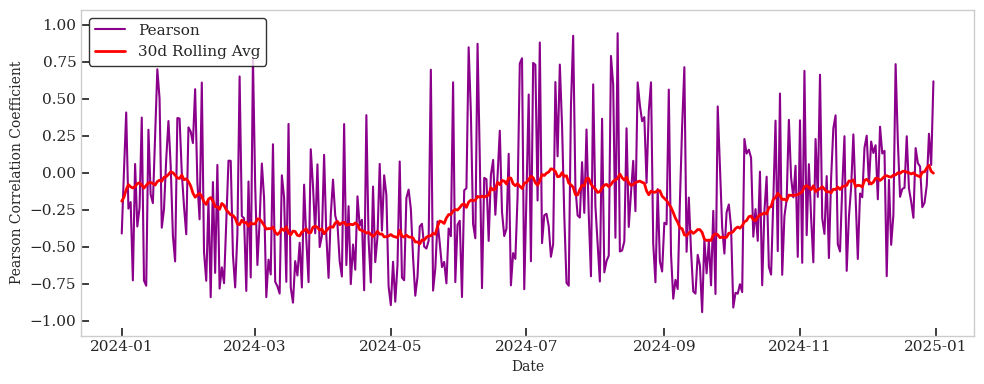

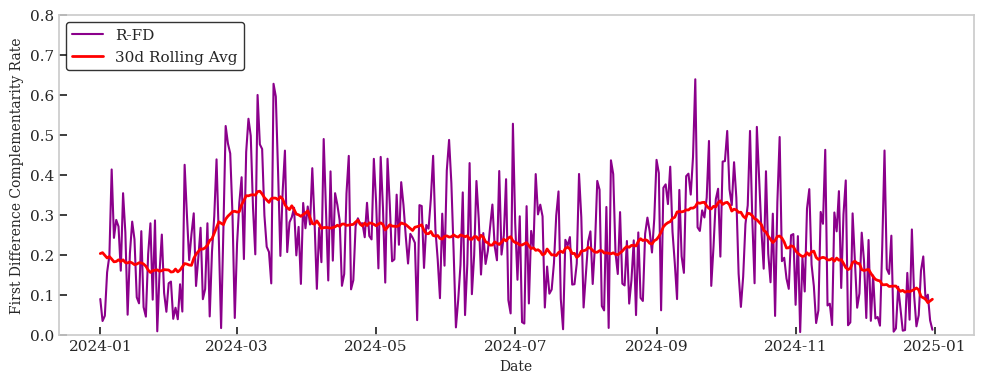

In [17]:
selected_area = ['NO1', 'NO2', 'NO3', 'NO4', 'NO5', 'SE1', 'SE2', 'SE3', 'DK1', 'DK2']
selected_df = ds_country.sel(area=selected_area)
df_wind = selected_df['wind_power_mw_2025'].sum(dim='area').to_series()
df_solar = selected_df['pv_power_mw_2025'].sum(dim='area').to_series()
# selected_area = 'Germany (DE)'
# norway_df = ds_country.sel(area=selected_area)
# df_wind = norway_df['wind_power_mw_2025'].to_series()
# df_solar = norway_df['pv_power_mw_2025'].to_series()

df_daily_metrics = calculate_daily_metrics(df_wind, df_solar)
df_daily_metrics.index = pd.to_datetime(df_daily_metrics.index)

# Calculate monthly rolling averages (window=30 days)
rolling_pearson = df_daily_metrics['Pearson_r'].rolling(window=30, min_periods=1, center=True).mean()
rolling_fd = df_daily_metrics['R_FD'].rolling(window=30, min_periods=1, center=True).mean()

plt.rcParams['font.family'] = 'serif' 
# --- Pearson Correlation Plot ---
date_fmt = mdates.DateFormatter('%Y-%m')
fig1, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(df_daily_metrics.index, df_daily_metrics['Pearson_r'], color='darkmagenta', linewidth=1.5, label='Pearson')
ax1.plot(df_daily_metrics.index, rolling_pearson, color='red', linewidth=2, label='30d Rolling Avg')
ax1.set_ylabel('Pearson Correlation Coefficient', fontsize=10)
ax1.set_ylim(-1.1, 1.1)
ax1.legend(loc='upper left', frameon=True, edgecolor='black')
ax1.tick_params(direction='in', bottom=True, left=True)
ax1.grid(False)
for spine in ax1.spines.values():
    spine.set_linewidth(1.0)
ax1.set_xlabel('Date', fontsize=10)
ax1.xaxis.set_major_formatter(date_fmt)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.tight_layout()
plt.savefig(output_dir / f"daily_pearson_timeseries_{YEARS[0]}-{YEARS[-1]}.svg", bbox_inches="tight", dpi=400)
plt.show()

# --- R-FD Plot ---
fig2, ax2 = plt.subplots(figsize=(10, 4))

ax2.plot(df_daily_metrics.index, df_daily_metrics['R_FD'], color='darkmagenta', linewidth=1.5, label='R-FD')
ax2.plot(df_daily_metrics.index, rolling_fd, color='red', linewidth=2, label='30d Rolling Avg')
ax2.set_ylabel('First Difference Complementarity Rate', fontsize=10)
ax2.set_ylim(0, 0.8)
ax2.set_xlabel('Date', fontsize=10)
ax2.legend(loc='upper left', frameon=True, edgecolor='black')
ax2.tick_params(direction='in', bottom=True, left=True)
ax2.grid(False)
ax2.xaxis.set_major_formatter(date_fmt)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.tight_layout()
plt.savefig(output_dir / f"daily_rfd_timeseries_{YEARS[0]}-{YEARS[-1]}.svg", bbox_inches="tight", dpi=400)
plt.show()


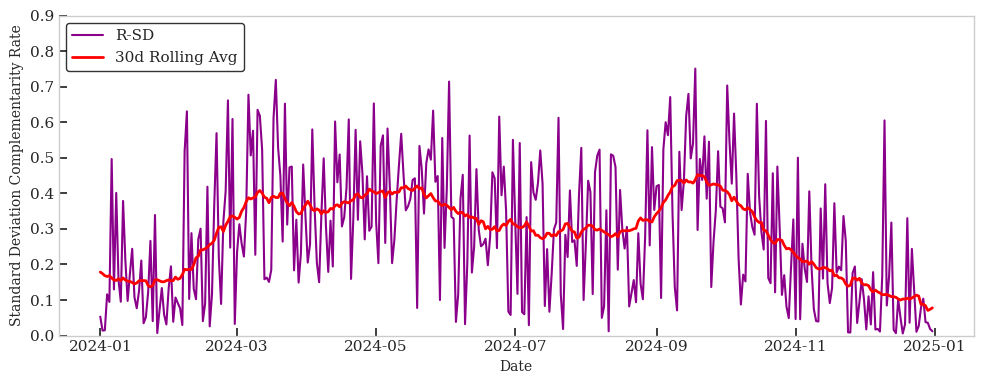

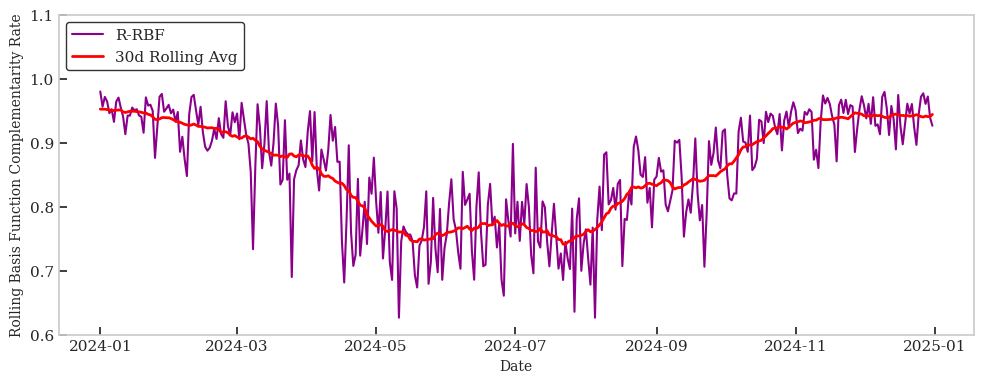

In [20]:
# --- R-SD Plot ---
fig1, ax1 = plt.subplots(figsize=(10, 4))

rolling_sd = df_daily_metrics['R_SD'].rolling(window=30, min_periods=1, center=True).mean()
rolling_rbf = df_daily_metrics['R_RBF'].rolling(window=30, min_periods=1, center=True).mean()

ax1.plot(df_daily_metrics.index, df_daily_metrics['R_SD'], color='darkmagenta', linewidth=1.5, label='R-SD')
ax1.plot(df_daily_metrics.index, rolling_sd, color='red', linewidth=2, label='30d Rolling Avg')
ax1.set_ylabel('Standard Deviation Complementarity Rate', fontsize=10)
ax1.set_ylim(0, 0.9)
ax1.legend(loc='upper left', frameon=True, edgecolor='black')
ax1.tick_params(direction='in', bottom=True, left=True)
ax1.grid(False)
for spine in ax1.spines.values():
    spine.set_linewidth(1.0)
ax1.set_xlabel('Date', fontsize=10)
ax1.xaxis.set_major_formatter(date_fmt)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.tight_layout()
plt.savefig(output_dir / f"daily_rsd_timeseries_{YEARS[0]}-{YEARS[-1]}.svg", bbox_inches="tight", dpi=400)
plt.show()

# --- R-RBF Plot ---
fig2, ax2 = plt.subplots(figsize=(10, 4))

ax2.plot(df_daily_metrics.index, df_daily_metrics['R_RBF'], color='darkmagenta', linewidth=1.5, label='R-RBF')
ax2.plot(df_daily_metrics.index, rolling_rbf, color='red', linewidth=2, label='30d Rolling Avg')
ax2.set_ylabel('Rolling Basis Function Complementarity Rate', fontsize=10)
ax2.set_ylim(0.6, 1.1)
ax2.set_xlabel('Date', fontsize=10)
ax2.legend(loc='upper left', frameon=True, edgecolor='black')
ax2.tick_params(direction='in', bottom=True, left=True)
ax2.grid(False)
ax2.xaxis.set_major_formatter(date_fmt)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.tight_layout()
plt.savefig(output_dir / f"daily_rrbf_timeseries_{YEARS[0]}-{YEARS[-1]}.svg", bbox_inches="tight", dpi=400)
plt.show()

### Interpretation
*   **Pearson Correlation**: Values close to -1 indicate strong complementarity (when wind is up, sun is down).
*   **R_SD, R_RBF, R_FD**: Values close to 1 indicate strong complementarity (fluctuations cancel each other out).

## 4. Analysis II: Offshore vs. Onshore Wind Complementarity



Since the country aggregated files lump wind together, we must use the **Gridded** dataset (`pv_wind_grid.nc`) which contains `wind_onshore_mw` and `wind_offshore_mw` separately.



**Note:** To analyze specific countries strictly, a shapefile mask would be required. Here, we analyze the **entire European fleet** (summed over the whole grid) or select approximate bounding boxes for regions with high offshore activity (e.g., North Sea).

--- Whole Europe Offshore vs Onshore Complementarity ---
Pearson_r: 0.0802
R_SD: 0.0004
R_RBF: 0.7392
R_FD: 0.0009


/home/nab015/.conda/envs/energy_mod/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nab015/.conda/envs/energy_mod/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- North Sea Region (Approx) Offshore vs Onshore ---
Pearson_r: nan
R_SD: 0.0000
R_RBF: 0.0000
R_FD: 0.0000


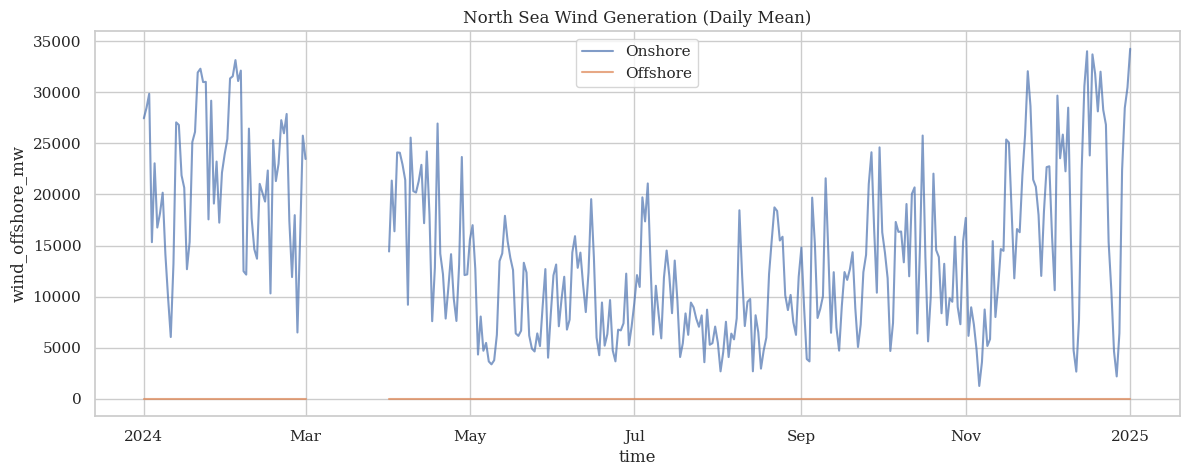

In [8]:
def load_grid_data(years):
    files = []
    for year in years:
        files.extend(sorted(list((GRID_DIR / year).glob("*_pv_wind_grid.nc"))))
    
    if not files: return None
    return xr.open_mfdataset(files, concat_dim="time", combine="nested")

ds_grid = load_grid_data(YEARS)

if ds_grid is not None:
    # 1. Total European Analysis (Sum over all x, y)
    # This gives the complementarity of the entire continental fleet
    total_onshore = ds_grid['wind_onshore_mw'].sum(dim=['y', 'x']).compute()
    total_offshore = ds_grid['wind_offshore_mw'].sum(dim=['y', 'x']).compute()
    
    europe_metrics = calculate_metrics(total_onshore.to_series(), total_offshore.to_series())
    print("--- Whole Europe Offshore vs Onshore Complementarity ---")
    for k, v in europe_metrics.items():
        print(f"{k}: {v:.4f}")
        
    # 2. Regional Approximation (North Sea Box)
    # Approx Bounds: Lat 51 to 60, Lon 0 to 10 (Roughly)
    # Assuming the grid has coordinates latitude/longitude
    ns_mask = (ds_grid.latitude > 51) & (ds_grid.latitude < 60) & (ds_grid.longitude > 0) & (ds_grid.longitude < 10)
    
    ns_onshore = ds_grid['wind_onshore_mw'].where(ns_mask).sum(dim=['y', 'x']).compute()
    ns_offshore = ds_grid['wind_offshore_mw'].where(ns_mask).sum(dim=['y', 'x']).compute()
    
    ns_metrics = calculate_metrics(ns_onshore.to_series(), ns_offshore.to_series())
    print("\n--- North Sea Region (Approx) Offshore vs Onshore ---")
    for k, v in ns_metrics.items():
        print(f"{k}: {v:.4f}")
        
    # Plotting
    fig, ax = plt.subplots(figsize=(14, 5))
    # Resample to daily for cleaner plot
    ns_onshore.resample(time='1D').mean().plot(ax=ax, label='Onshore', alpha=0.7)
    ns_offshore.resample(time='1D').mean().plot(ax=ax, label='Offshore', alpha=0.7)
    ax.set_title("North Sea Wind Generation (Daily Mean)")
    ax.legend()
    plt.show()

## 5. Weather Dependent Analysis (Intermittency)



We use the **2025 Fleet Capacity** applied to historical weather data. By loading multiple years (if available), we can see how the same power plants perform under different weather years.



**Metric:** Coefficient of Variation (CV) = $\sigma / \mu$.

In [21]:
# YEARS = [str(y) for y in range(2023, 2025)] 
YEARS = ["2024"]
output_dir = Path(f'/Data/gfi/vindenergi/nab015/figures/intermittency')

/tmp/ipykernel_1455606/189261935.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([extract_code(label) for label in df_melted['area'].unique()], fontsize=9, rotation=90, ha='right')


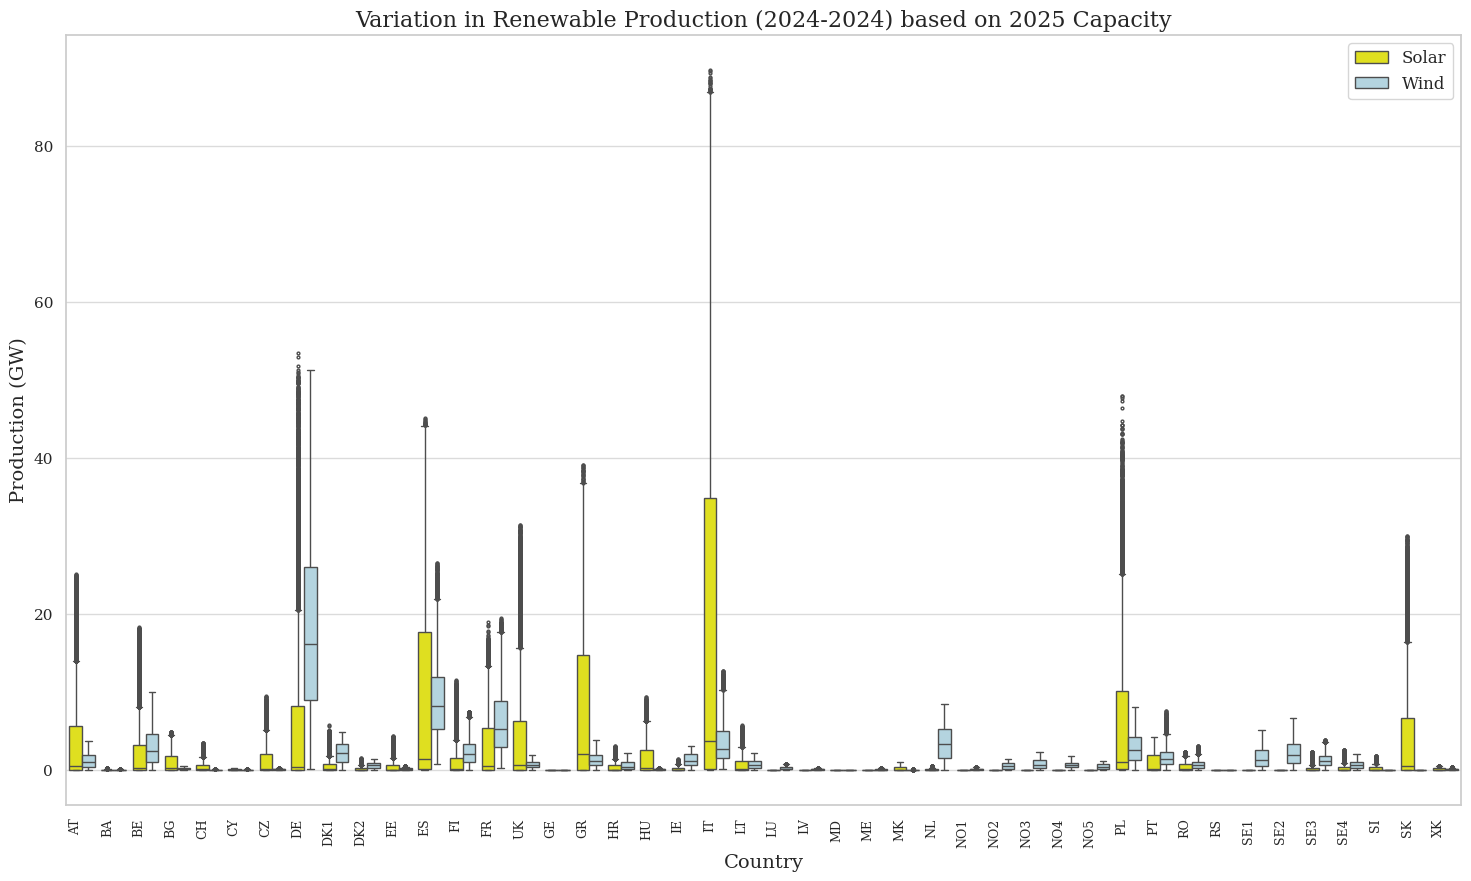

In [22]:
try:

    df_raw = ds_country[['pv_power_mw_2025', 'wind_power_mw_2025']].to_dataframe().reset_index()
    df_melted = df_raw.melt(
        id_vars=['time', 'area'], 
        value_vars=['pv_power_mw_2025', 'wind_power_mw_2025'],
        var_name='Type', 
        value_name='MW'
    )
    
    type_map = {
        'pv_power_mw_2025': 'Solar',
        'wind_power_mw_2025': 'Wind' 
    }
    df_melted['Type'] = df_melted['Type'].map(type_map)
    
    df_melted['GW'] = df_melted['MW'] / 1000.0
    
    fig, ax = plt.subplots(figsize=(18, 10))
    
    palette = {"Solar": "yellow", "Wind": "lightblue"}
    
    sns.boxplot(
        data=df_melted,
        x='area',
        y='GW',
        hue='Type',
        palette=palette,
        linewidth=1,
        fliersize=2, 
        ax=ax
    )
    
    ax.set_title(f"Variation in Renewable Production ({min(YEARS)}-{max(YEARS)}) based on 2025 Capacity", fontsize=16)
    ax.set_ylabel("Production (GW)", fontsize=14)
    ax.set_xlabel("Country", fontsize=14)
    ax.set_xticklabels([extract_code(label) for label in df_melted['area'].unique()], fontsize=9, rotation=90, ha='right')
    ax.legend(title=None, fontsize=12)
    
    ax.grid(True, which='both', axis='y', linestyle='-', alpha=0.7)
    
    #Optional: Save figure
    fig.savefig(output_dir / f"production_boxplot_2025_scenario_{YEARS[0]}-{YEARS[-1]}.svg", dpi=400)

except Exception as e:
    print(f"An error occurred: {e}")

### Coefficient of Variation (normalized standard deviation)

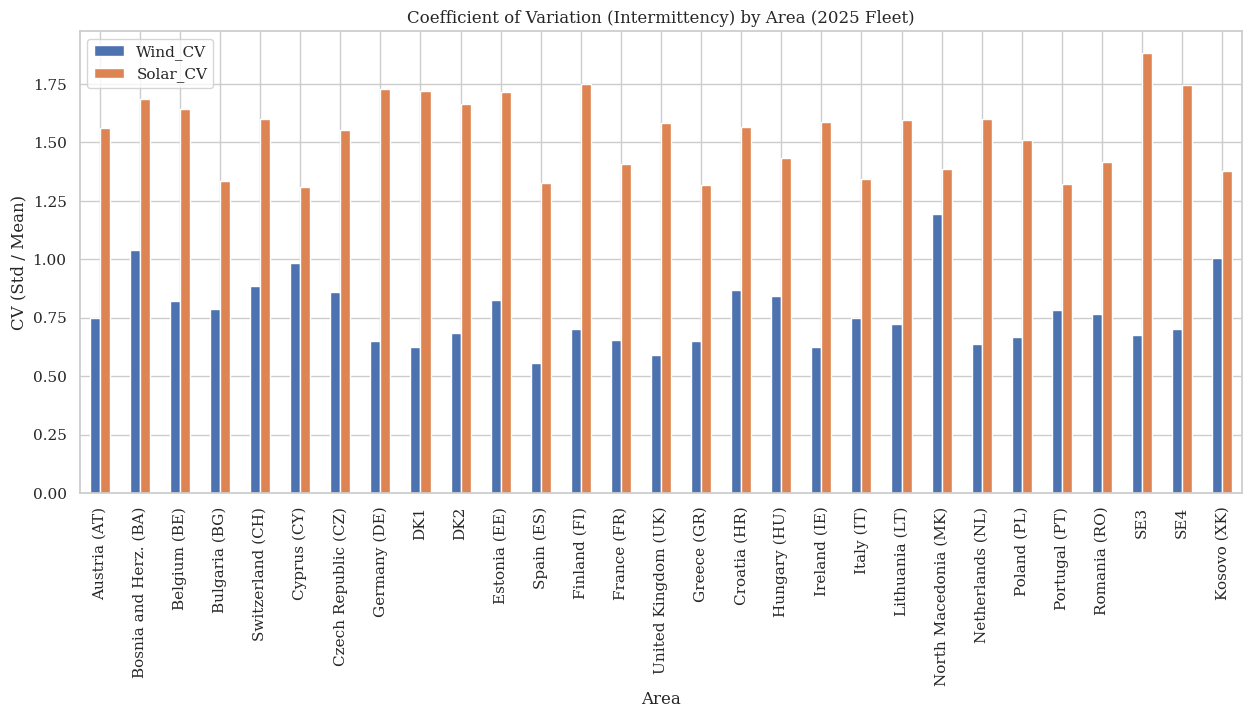

In [23]:
cv_results = []

for area in ds_country.area.values:
    data = ds_country.sel(area=area)
    
    #Wind
    w = data['wind_power_mw_2025']
    if w.mean() > 0:
        cv_w = w.std() / w.mean()
    else:
        cv_w = np.nan
        
    #Solar
    s = data['pv_power_mw_2025']
    if s.mean() > 0:
        cv_s = s.std() / s.mean()
    else:
        cv_s = np.nan
        
    cv_results.append({'Area': area, 'Wind_CV': float(cv_w), 'Solar_CV': float(cv_s)})

df_cv = pd.DataFrame(cv_results).dropna().set_index('Area')

fig, ax = plt.subplots(figsize=(15, 6))
df_cv[['Wind_CV', 'Solar_CV']].plot(kind='bar', ax=ax)
ax.set_title("Coefficient of Variation (Intermittency) by Area (2025 Fleet)")
ax.set_ylabel("CV (Std / Mean)")
plt.savefig(output_dir / f"coefficient_of_variation_2025_scenario_{YEARS[0]}-{YEARS[-1]}.svg", bbox_inches="tight", dpi=400)

### Monthly Variability Boxplots
To see seasonal effects (as mentioned in the article), we look at the distribution of production per month for a major country (e.g., Germany).

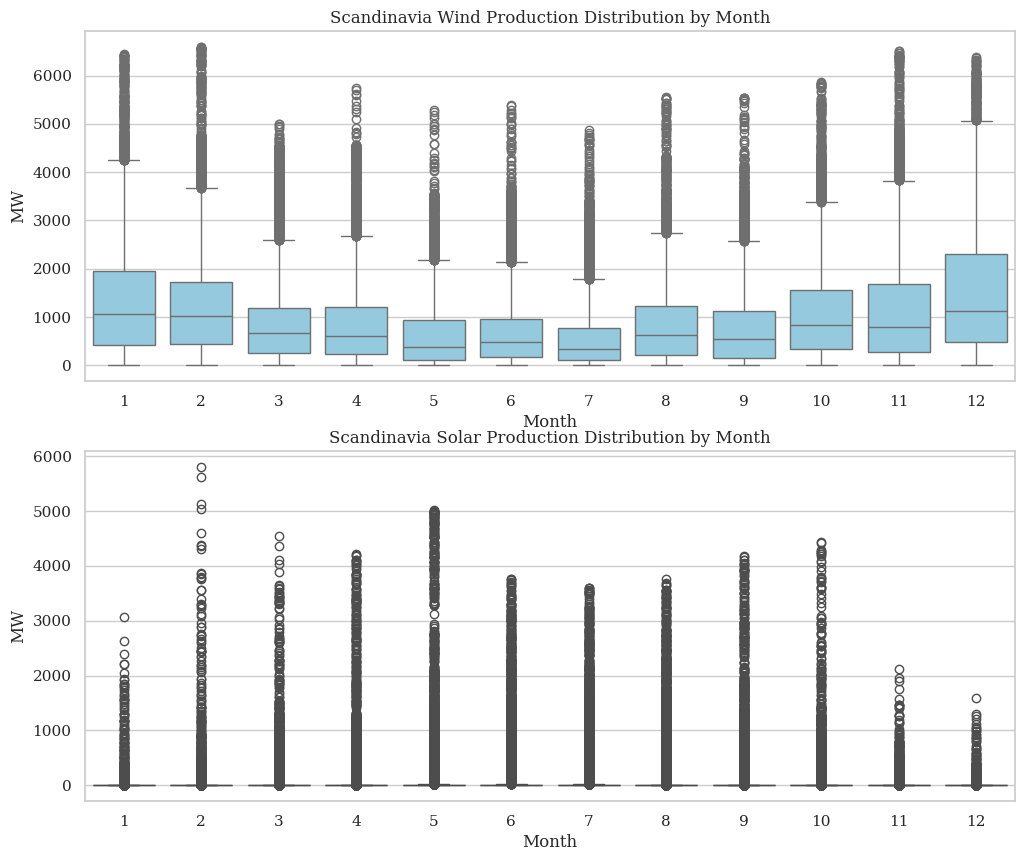

In [27]:
selected_df = ds_country.sel(area=selected_area)
                
df_selected = selected_df[['wind_power_mw_2025', 'pv_power_mw_2025']].to_dataframe()
df_selected['Month'] = df_selected.index.get_level_values('time').month
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
sns.boxplot(data=df_selected, x='Month', y='wind_power_mw_2025', ax=ax1, color='skyblue')
ax1.set_title(f"Scandinavia Wind Production Distribution by Month")
ax1.set_ylabel("MW")
    
sns.boxplot(data=df_selected, x='Month', y='pv_power_mw_2025', ax=ax2, color='orange')
ax2.set_title(f"Scandinavia Solar Production Distribution by Month")
ax2.set_ylabel("MW")
    
plt.savefig(output_dir / f"production_boxplot_2025_scenario_{YEARS[0]}-{YEARS[-1]}.svg", dpi=400)